In [1]:
import torch
import matplotlib.pyplot as plt
import copy
from score_models import VE, VP
from dataclasses import dataclass
from torch import distributions

import numpy as np
import torch.nn as nn
from scipy.stats import norm

from torch import Tensor
from scipy.spatial import Voronoi, voronoi_plot_2d

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    'font.size': 18,
})

# Set parameters
device = torch.device('cpu')

# set seed
torch.manual_seed(0)
np.random.seed(1)

## Define Data

<Figure size 200x200 with 0 Axes>

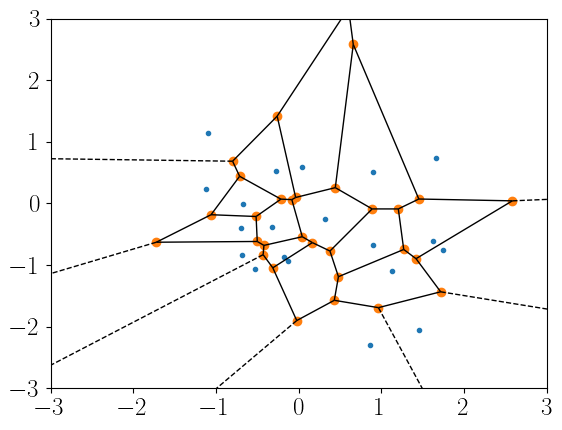

In [2]:
# load data from file
data = np.load('training_data.npy')
N, dim = data.shape

# define voronoi tesselation
vor = Voronoi(data)

# plot
plt.figure(figsize=(2,2))
fig = voronoi_plot_2d(vor)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()

## Define models

In [3]:
from score_models import VE, VP
model = VP()
model.eps = 0.

from score_models import GMM_score

# define GMM
gmm_train = GMM_score(torch.tensor(data, dtype=torch.float32), model.marginal_prob_mean, model.marginal_prob_std)

# test network
dim = data.shape[1]
rand_x = torch.randn(1000, dim).to(device)
rand_t = torch.rand(1,) * torch.ones((1000,1))
print(gmm_train(rand_x, rand_t[:,0]).shape)

torch.Size([1000, 2])


## Compute trajectories

In [4]:
# define latent samples
batch_size = 30
latents = torch.randn(batch_size, dim).to(device)

# evaluate ODE and SDE paths
model.eps = 1e-6
GMM_t, GMM_x = model.ODEsampler(gmm_train, latents)

# evaluate the ODE weights
GMMweights = torch.zeros((len(GMM_t), batch_size, gmm_train.train_data.shape[0]))
for (j,tj) in enumerate(GMM_t):
    batch_time = torch.ones(batch_size, device=latents.device) * tj
    GMMweights[j,:,:] = gmm_train.pdf_weights(GMM_x[:,:,j], batch_time)

/opt/anaconda3/envs/ML/lib/python3.8/site-packages/scipy/spatial/_plotutils.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


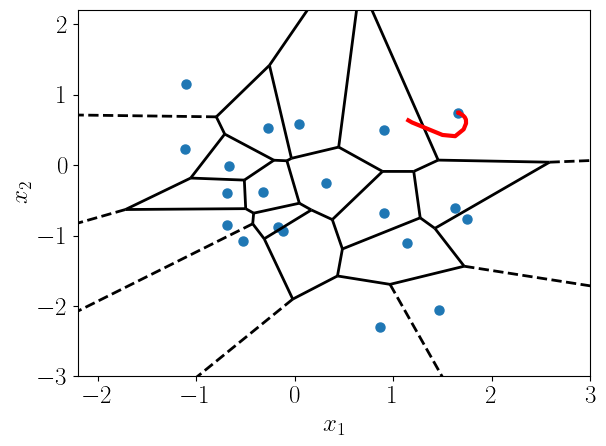

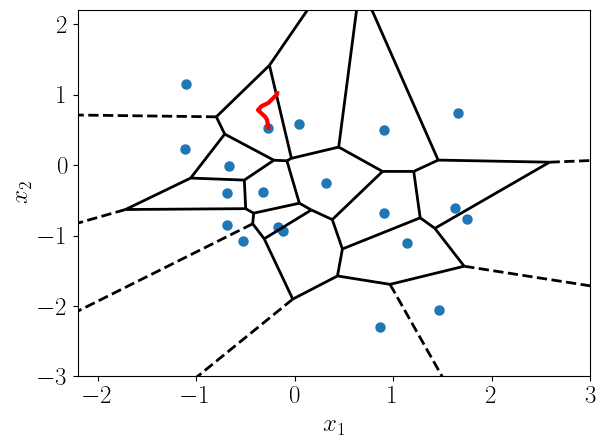

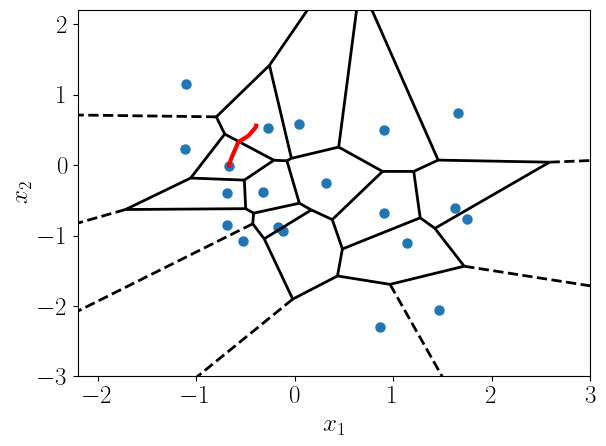

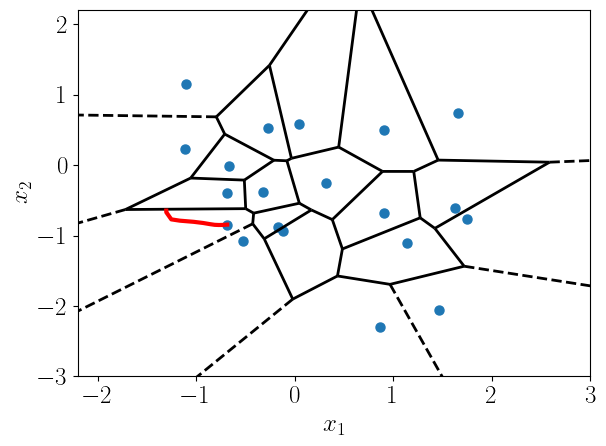

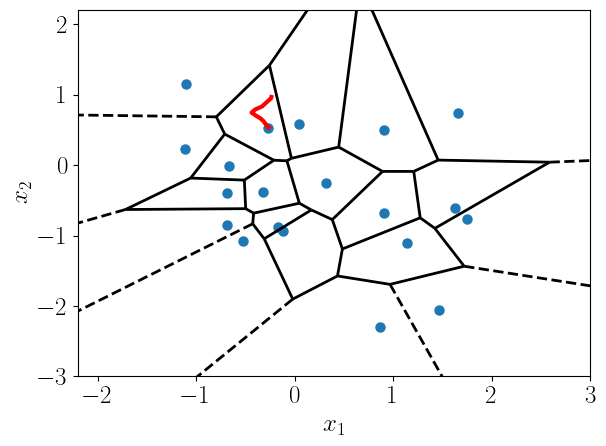

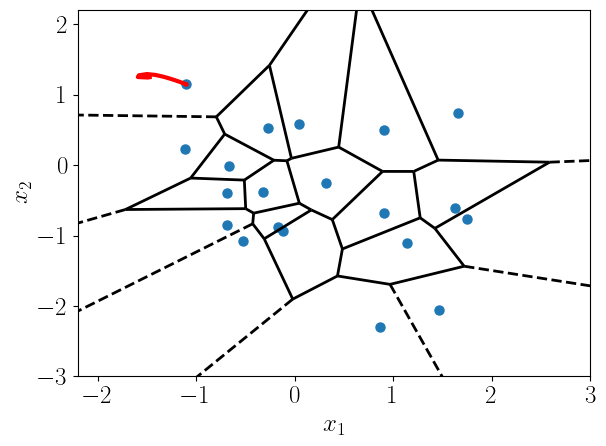

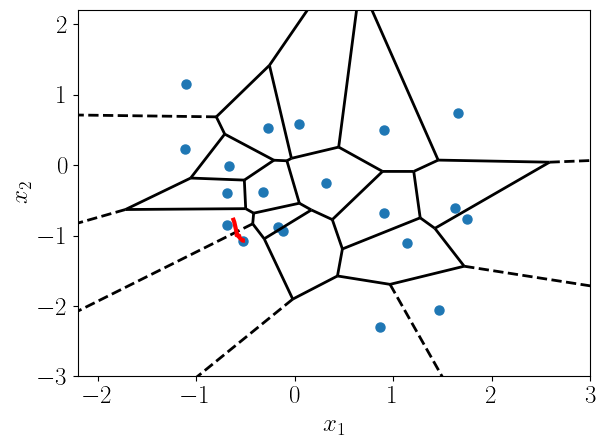

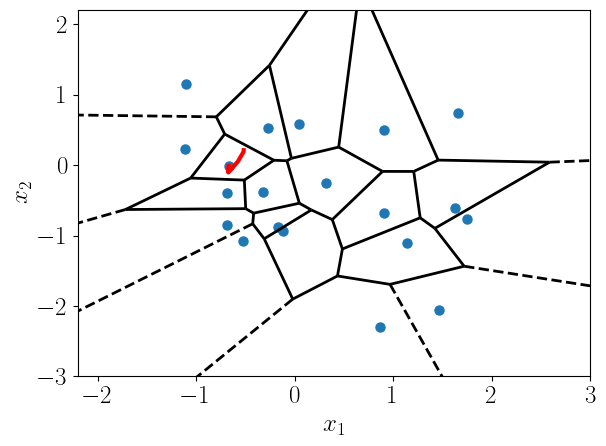

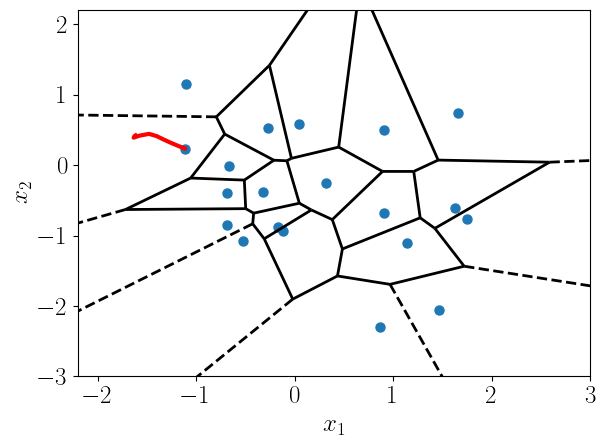

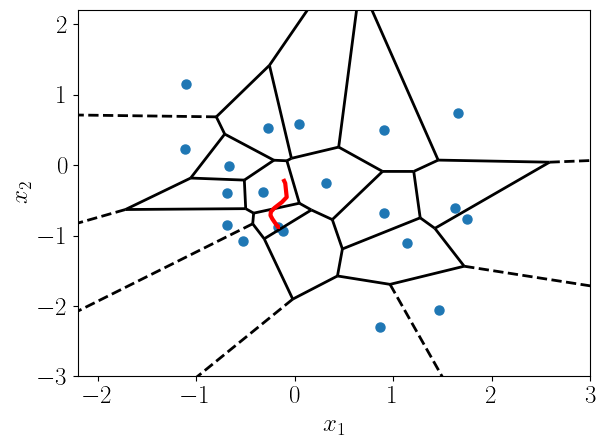

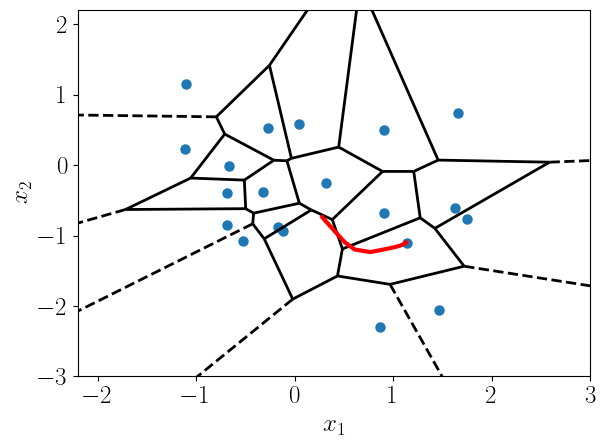

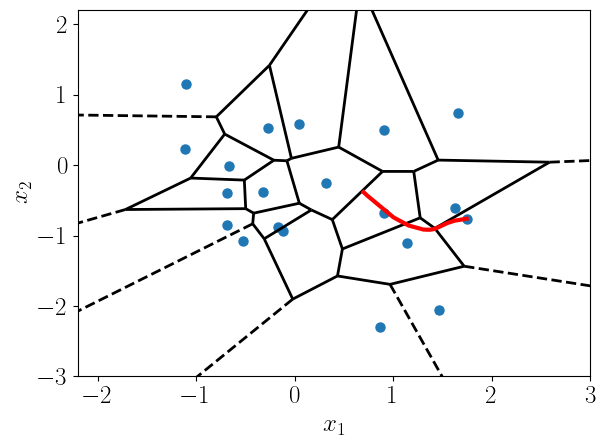

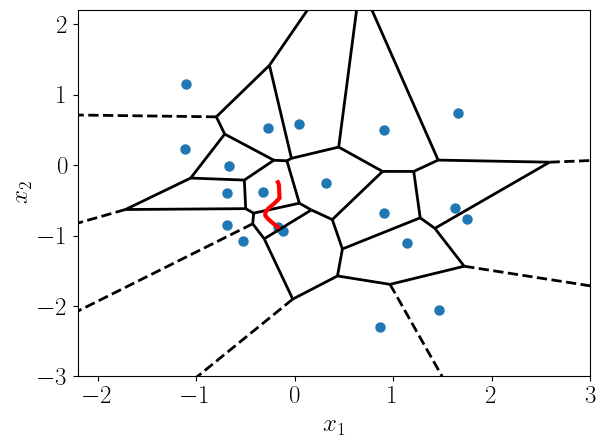

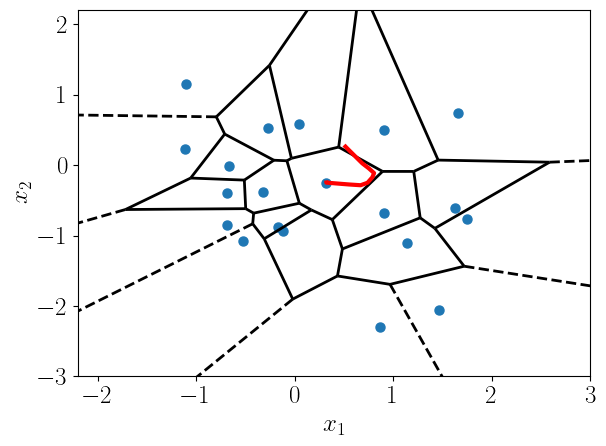

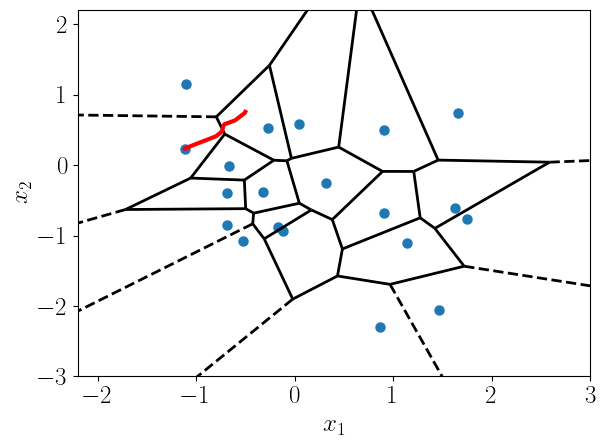

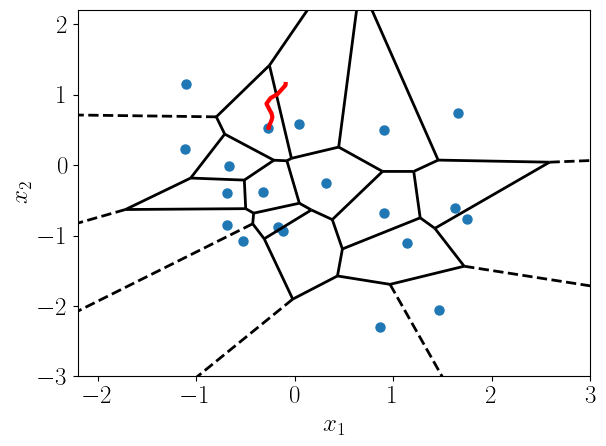

In [ ]:
folder = 'figures/VP'
# create folder to save results if it doesn't exixt
import os
if not os.path.exists(folder):
    os.makedirs(folder)

# plot trajectories
for i in range(batch_size):
    fig = voronoi_plot_2d(vor, show_vertices=False, line_width=2, point_size=13)
    plt.plot(GMM_x[i,0,:].detach().numpy(), GMM_x[i,1,:].detach().numpy(), '-r',linewidth=3)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.xlim(-2.2,3)
    plt.ylim(-3,2.2)
    plt.tight_layout()
    plt.savefig(folder + '/trajectory_'+str(i)+'.pdf')

# plot weights
for i in range(batch_size):
    plt.figure()
    plt.semilogx(GMM_t, GMMweights[:,i,:])
    plt.xlabel('Time, $t$')
    plt.ylabel('Normalized weights $w_n(t)$')
    plt.xlim(2e-2,1.2)
    plt.savefig(folder + '/weights_'+str(i)+'.pdf')

## Plot convergence

In [ ]:
plt.figure()
for i in range(batch_size):
    # compute distance to final point
    res_i = GMM_x[i,:,:]
    dist = torch.sqrt(torch.sum((res_i - res_i[:,-1][:,np.newaxis])**2, axis=0))
    plt.loglog(GMM_t, dist, '-r', alpha=0.8)
plt.loglog(GMM_t, 2*(GMM_t)**0.5, '--k', label = '$\mathcal{O}(t^{-0.5})$')
plt.xlabel('Time $t$')
plt.ylabel('$|x(t) - x^*|_2$')
plt.legend()
plt.xlim(1e-5,1)
plt.tight_layout()
plt.savefig(folder + '/time_convergence.pdf')
plt.show()